In [ ]:
# https://arxiv.org/abs/1406.2661
# https://machinelearningmastery.com/tour-of-generative-adversarial-network-models/
# https://jonathan-hui.medium.com/gan-a-comprehensive-review-into-the-gangsters-of-gans-part-1-95ff52455672
# https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html

# https://www.tensorflow.org/tutorials/generative/dcgan
# https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
# https://machinelearningmastery.com/how-to-train-a-progressive-growing-gan-in-keras-for-synthesizing-faces/
# https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/
# https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, LeakyReLU,MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Reshape, Flatten, Dropout, Embedding, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy

In [ ]:
def load_dataset():
  """
  """
  (X, _), (_, _) = cifar10.load_data()
  #X = np.expand_dims(X, axis=-1).astype('float32')
  X = (X - 127.5) / 127.5
  return X.astype('float32')

In [ ]:
def generate_batch_real(dataset, n_samples):
  """
  """
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = np.ones((n_samples, 1))
  return X, y

170500096/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
-1.0
1.0
(10, 32, 32, 3)
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


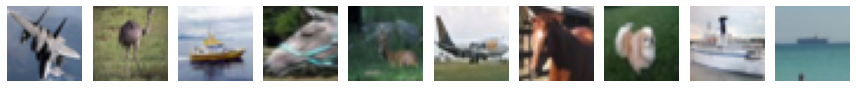

In [ ]:
X = load_dataset()
print(X.shape)
print(X.min())
print(X.max())

x_batch, y_batch = generate_batch_real(X, 10)
print(x_batch.shape)
print(y_batch.T)

plt.figure(figsize=(12, 3))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.imshow((x_batch[i] + 1.0) / 2.0)
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def generate_batch_fake(generator, n_latent_dim, n_samples):
  """
  """
  x_input = np.random.randn(n_samples, n_latent_dim)
  X = generator.predict(x_input)
  y = np.zeros((n_samples, 1))
  return X, y

In [ ]:
def define_discriminator(in_shape=(32, 32, 3)):
  """
  """
  model = Sequential()
  model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  optim = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
  return model

In [ ]:
def define_generator(n_latent_dim):
  """
  """
  model = Sequential()
  model.add(Dense(128 * 8 * 8, input_dim=n_latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((8, 8, 128)))
  model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(3, (7, 7), activation='tanh', padding='same'))
  return model

In [ ]:
def define_gan(generator, discriminator):
  """
  """
  discriminator.trainable = False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  optim = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=optim)
  return model

In [ ]:
def visualize_batch(generator, n_latent_dim, n_samples=20):
  """
  """
  latent = np.random.randn(n_samples, n_latent_dim)
  images = generator.predict(latent)

  plt.figure(figsize=(18, 3))
  for i in range(n_samples):
    plt.subplot(1, 20, i+1)
    plt.imshow((images[i] + 1.0) / 2.0)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
def train(g_model, d_model, gan_model, dataset, n_latent_dim, n_epochs=50, batch_size=256, visualize=False):
  """
  """
  n_batches = int(dataset.shape[0] / batch_size)
  half_batch_size = int(batch_size / 2)
  lista = []
  if visualize:
    visualize_batch(g_model, n_latent_dim, 20)

  for ind_epoch in range(n_epochs):
    print(f"Epoch {ind_epoch+1:2d}/{n_epochs} -- ", end='')
    for ind_batch in range(n_batches):
      # Discriminator - Real
      X_real, y_real = generate_batch_real(dataset, half_batch_size)
      d_loss_r, _ = d_model.train_on_batch(X_real, y_real)
      # Discriminator - Fake
      X_fake, y_fake = generate_batch_fake(g_model, n_latent_dim, half_batch_size)
      d_loss_f, _ = d_model.train_on_batch(X_fake, y_fake)

      # Generator
      X_gan = np.random.randn(batch_size, n_latent_dim)
      y_gan = np.ones((batch_size, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      if (ind_batch % 20) == 0:
        print('.', end='')

    print(' d_real=%.3f, d_fake=%.3f g=%.3f' % (d_loss_r, d_loss_f, g_loss))
    lista.append([d_loss_r,d_loss_f,g_loss])
    if visualize:
      visualize_batch(g_model, n_latent_dim, 20)
  return lista

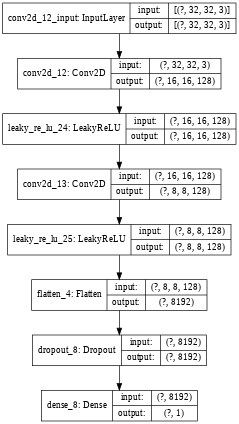

In [ ]:
# Test everything
n_latent_dim = 128

discriminator = define_discriminator()
generator = define_generator(n_latent_dim)
gan_model = define_gan(generator, discriminator)
plot_model(discriminator, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)
#X = load_dataset()
#train(generator, discriminator, gan_model, X, n_latent_dim, n_epochs=50, batch_size=64, visualize=True)

In [ ]:
# Mini proyecto final / 3er parcial
# -- 1) Diseña una GAN convolucional (DCGAN) para generar imágenes similares a la
# base de datos CIFAR10. Puedes usar el código de este notebook como modelo base.
# -- 2) Incluye algún tipo de estructura a las entradas del generador y del dis-
# criminador, de manera que puedan ayudar a mejorar la generación de datos por 
# clase. Puedes usar el código visto en clase para redes siamesas.
# -- 3) Implementa la función de costo Wasserstein (convierte la GAN en WGAN), y
# verifica si hay alguna mejora en el desempeño de la red desde el punto de
# vista numérico. Puedes ayudarte de la referencia incluida en este notebook.

# Entrega por equipo.
# Preparar una presentación que incluya: Solución propuesta, resultados obtenidos,
# problemas encontrados, sugerencias de mejora. La presentación debe ser corta y
# concisa, quizás unas 5 diapositivas y presentable en 10 minutos.
# Evaluación: presentación en clase. Diciembre 2, 2021.
# Entregables: notebook con solución, y presentación en PDF. Enviar por correo.

**Parte1**

In [ ]:
def define_discriminator2(in_shape=(32, 32, 3)):
  """
  """
  model = Sequential()
  model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  optim = Adam(lr=0.0002, beta_1=0.4)
  model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
  return model

In [ ]:
def define_generator2(n_latent_dim):
  """
  """
  model = Sequential()
  model.add(Dense(128 * 8 * 8, input_dim=n_latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((8, 8, 128)))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(3, (7, 7), activation='tanh', padding='same'))
  return model

In [ ]:
def define_gan2(generator, discriminator):
  """
  """
  discriminator.trainable = False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  optim = Adam(lr=0.0002, beta_1=0.4)
  model.compile(loss='binary_crossentropy', optimizer=optim)
  return model

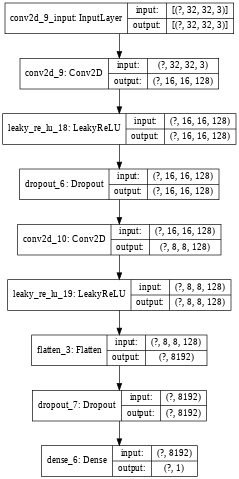

In [ ]:
n_latent_dim = 128

discriminator = define_discriminator2()
generator = define_generator2(n_latent_dim)
gan_model = define_gan2(generator, discriminator)
plot_model(discriminator, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
# Test everything
n_latent_dim = 128

discriminator = define_discriminator2()
generator = define_generator2(n_latent_dim)
gan_model = define_gan2(generator, discriminator)

X = load_dataset()
l_tabla = train(generator, discriminator, gan_model, X, n_latent_dim, n_epochs=50, batch_size=64, visualize=True)
dataf = pd.DataFrame(l_tabla, columns=["d_real", "d_fake", "g"])
dataf

Output hidden; open in https://colab.research.google.com to view.

**Parte 2**

In [ ]:
# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test  = (x_test.astype('float32')  - 127.5) / 127.5

x_train = x_train.reshape((x_train.shape[0], 32, 32, 3))
x_test  = x_test.reshape((x_test.shape[0], 32, 32, 3))


170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

n_latent_dim=128

In [ ]:
#Definir modelo
def define_discriminator_c(in_shape=(32,32,3), n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.4)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

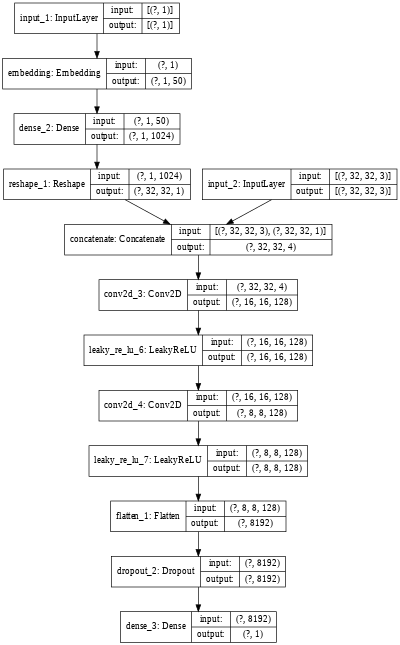

In [ ]:
discriminator = define_discriminator_c()

plot_model(discriminator, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [49]:
#Definir Generador
def define_generator_c(latent_dim, n_classes=10):
  in_lab = Input(shape=(1,), name='INPUT2')
  h2 = Embedding(n_classes, 50)(in_lab)
  h2 = Dense(64, activation='relu')(h2)
  h2 = Reshape((8,8,1))(h2)

  in_img = Input(shape=(32, 32, 3), name='INPUT1')
  h1 = Dense(128 * 8 * 8, input_dim=n_latent_dim)(in_img)
  h1 = LeakyReLU(alpha=0.2)(h1)
  h1 = Reshape((8, 8, 128))(h1)
  
  latent = Concatenate(axis=1, name='LATENT_A')([h1, h2])
  latent = Dense(1024, activation='relu', name='LATENT_B')(latent)

  h1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(latent)
  h1 = LeakyReLU(alpha=0.2)(h1)
  h1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(latent)
  h1 = LeakyReLU(alpha=0.2)(h1)
  out_img = Conv2D(3, (7, 7), activation='tanh', padding='same', name='OUT1')(h1)

	# define model
  model = Model([in_img, in_lab], out_img)
  return model

In [ ]:
generator = define_generator_c(n_latent_dim)

plot_model(generator, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
#Definir GAN
def define_gan_c(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
cgan_model = define_gan_c(generator, discriminator)

plot_model(cgan_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
# load images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = cifar10.load_data()
	# expand to 3d, e.g. add channels
	X = (trainX - 127.5) / 127.5
	return [X.astype('float32'),trainy]


# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [ ]:
# train
def train(g_model, d_model, gan_model, dataset, n_latent_dim, n_epochs=50, batch_size=256, visualize=False):
  """
  """
  n_batches = int(dataset[0].shape[0] / batch_size)
  half_batch_size = int(batch_size / 2)

  if visualize:
    visualize_batch(g_model, n_latent_dim, 20)

  for ind_epoch in range(n_epochs):
    print(f"Epoch {ind_epoch+1:2d}/{n_epochs} -- ", end='')
    for ind_batch in range(n_batches):
      # Discriminator - Real
      [X_real, labels_real], y_real = generate_batch_real(dataset, half_batch_size)
      d_loss_r, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      # Discriminator - Fake
      [X_fake, labels], y_fake = generate_fake_samples(g_model, n_latent_dim, half_batch_size)
      d_loss_f, _ = d_model.train_on_batch([X_fake, labels], y_fake)

      # Generator
      [X_gan, labels_input] = generate_latent_points(n_latent_dim, n_batch)
      y_gan = np.ones((batch_size, 1))
      g_loss = gan_model.train_on_batch([X_gan, labels_input], y_gan)
      if (ind_batch % 20) == 0:
        print('.', end='')

    print(' d_real=%.3f, d_fake=%.3f g=%.3f' % (d_loss_r, d_loss_f, g_loss))
    if visualize:
      visualize_batch(g_model, n_latent_dim, 20)

In [ ]:
discriminator = define_discriminator_c()
generator = define_generator_c(n_latent_dim)
gan_model = define_gan_c(generator, discriminator)

X = load_real_samples()

train(generator, discriminator, gan_model, X, n_latent_dim, n_epochs=50, batch_size=64, visualize=True)

Parte 3


In [ ]:
# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test  = (x_test.astype('float32')  - 127.5) / 127.5

x_train = x_train.reshape((x_train.shape[0], 32, 32, 3))
x_test  = x_test.reshape((x_test.shape[0], 32, 32, 3))

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

In [ ]:
def wasserstein_loss(y_true,y_pred):
  """
  """
  return -tf.keras.backend.mean(y_true * y_pred)

In [ ]:
def crit_loss(score_real,score_fake):
  return score_real - score_fake

def gen_w_loss(score_fake):
  return -score_fake

In [ ]:
def define_discriminator_w(in_shape=(32, 32, 3)):
  """
  """
  model = Sequential()
  model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='linear'))
  optim = RMSprop(lr=0.00005)
  model.compile(loss=wasserstein_loss, optimizer=optim, metrics=['accuracy'])
  return model

In [ ]:
def define_generator_w(n_latent_dim):
  """
  """
  model = Sequential()
  model.add(Dense(128 * 8 * 8, input_dim=n_latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((8, 8, 128)))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(3, (7, 7), activation='sigmoid', padding='same'))
  return model

In [ ]:
def define_gan_w(generator, discriminator):
  """
  """
  discriminator.trainable = False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  optim = RMSprop(lr=0.00005)
  model.compile(loss=wasserstein_loss, optimizer=optim)
  return model

In [ ]:
def train3_w(g_model, d_model, gan_model, dataset, n_latent_dim, n_epochs, batch_size, visualize=False,n_critic=5,clip=1):
  """
  """
  n_batches = int(dataset.shape[0] / batch_size)
  half_batch_size = int(batch_size / 2)
  lista = []

  if visualize:
    visualize_batch(g_model, n_latent_dim, 20)

  for ind_epoch in range(n_epochs):
    print(f"Epoch {ind_epoch+1:2d}/{n_epochs} -- ", end='')
    for ind_batch in range(n_batches):
      for ind_crit in range(n_critic):
        # Discriminator - Real
        X_real, y_real = generate_batch_real(dataset, half_batch_size)
        d_loss_r, _ = d_model.train_on_batch(X_real, y_real)
        # Discriminator - Fake
        X_fake, y_fake = generate_batch_fake(g_model, n_latent_dim, half_batch_size)
        d_loss_f, _ = d_model.train_on_batch(X_fake, y_fake)

      critic_loss = crit_loss(d_loss_r,d_loss_f)
      # Generator
      X_gan = np.random.randn(batch_size, n_latent_dim)
      y_gan = np.ones((batch_size, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      if (ind_batch % 20) == 0:
        print('.', end='')
    generator_loss = gen_w_loss(g_loss)
    
    if critic_loss > clip:
      critic_loss = clip
    elif critic_loss < -clip:
      critic_loss = -clip

    if generator_loss > clip:
      generator_loss = clip
    elif generator_loss < -clip:
      generator_loss = -clip
    
    print(' crit_loss=%.3f, generator_loss=%.3f' % (critic_loss, generator_loss))
    lista.append([ind_epoch,critic_loss,generator_loss])
    if visualize:
      visualize_batch(g_model, n_latent_dim, 20)
  return lista

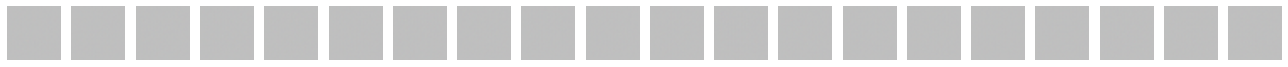

Epoch  1/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


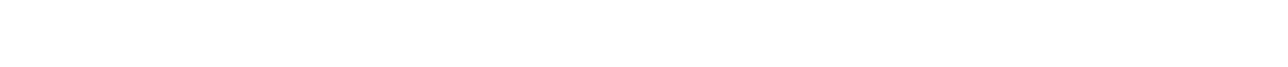

Epoch  2/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


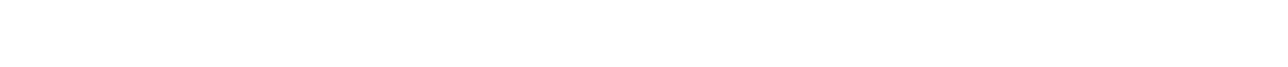

Epoch  3/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


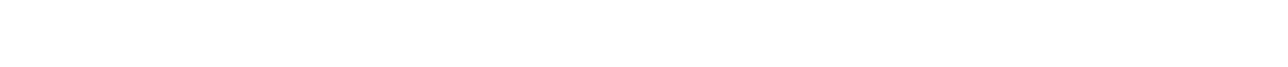

Epoch  4/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


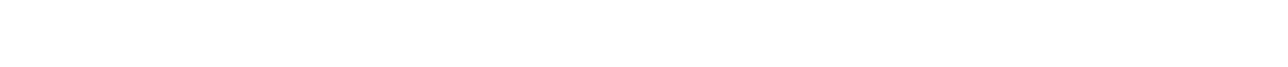

Epoch  5/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


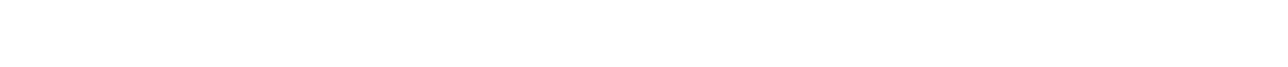

Epoch  6/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


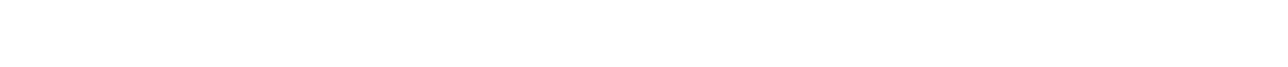

Epoch  7/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


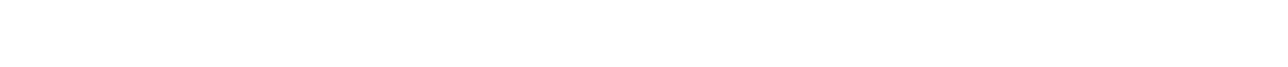

Epoch  8/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


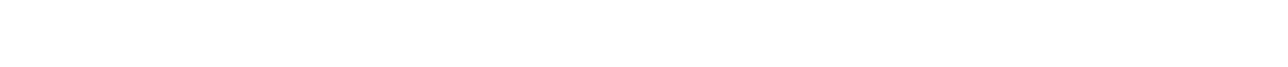

Epoch  9/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


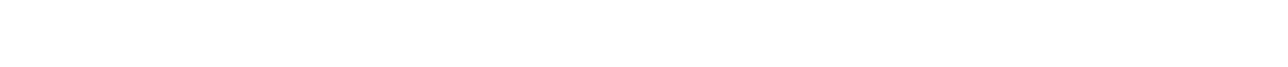

Epoch 10/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


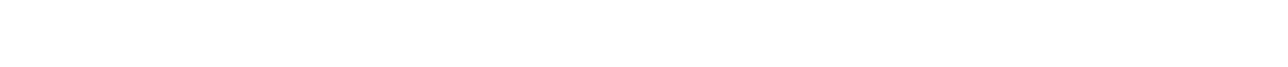

Epoch 11/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


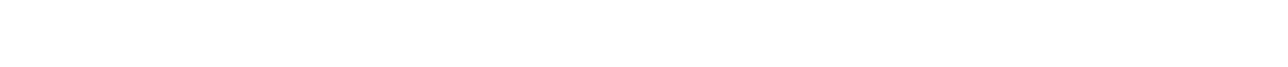

Epoch 12/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


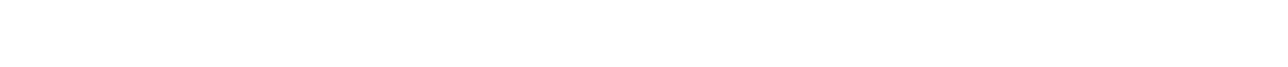

Epoch 13/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


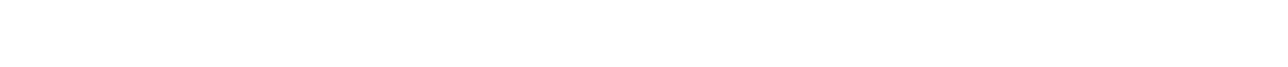

Epoch 14/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


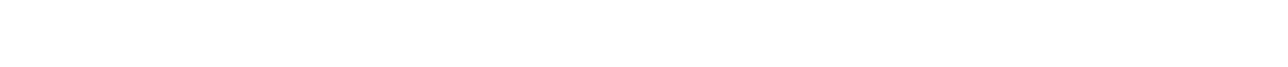

Epoch 15/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


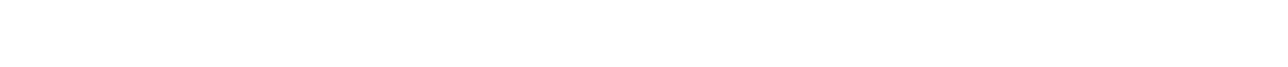

Epoch 16/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


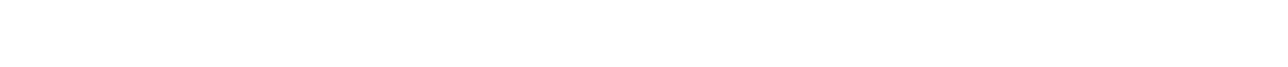

Epoch 17/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


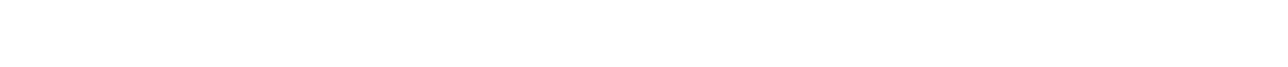

Epoch 18/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


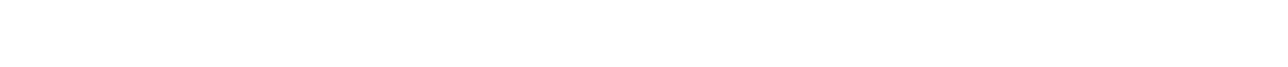

Epoch 19/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


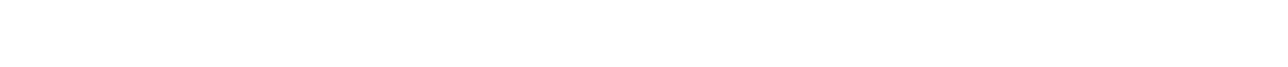

Epoch 20/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


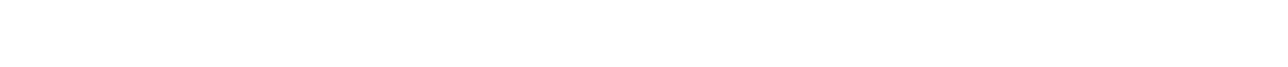

Epoch 21/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


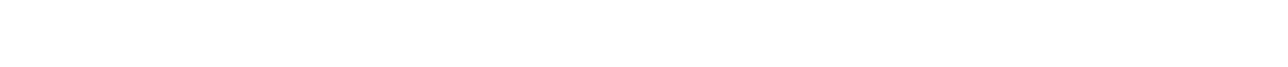

Epoch 22/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


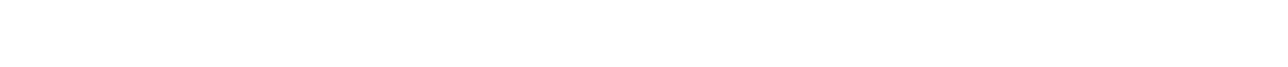

Epoch 23/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


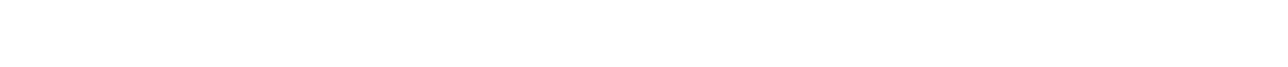

Epoch 24/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


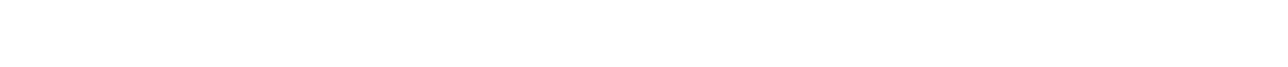

Epoch 25/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


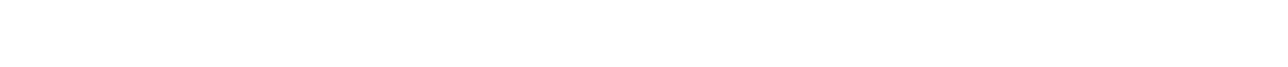

Epoch 26/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


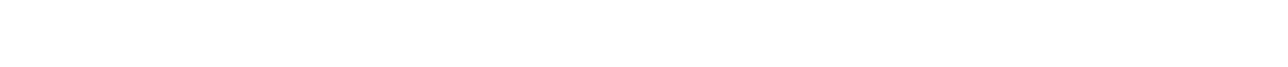

Epoch 27/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


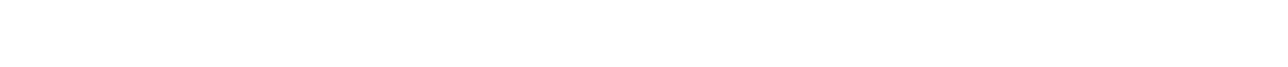

Epoch 28/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


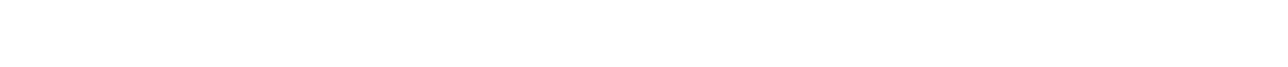

Epoch 29/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


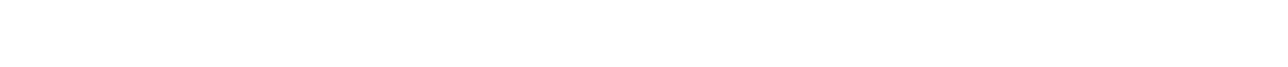

Epoch 30/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


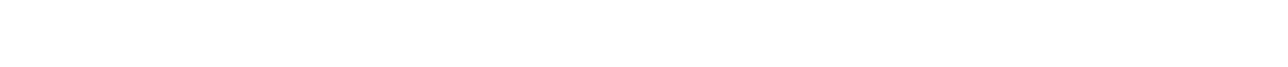

Epoch 31/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


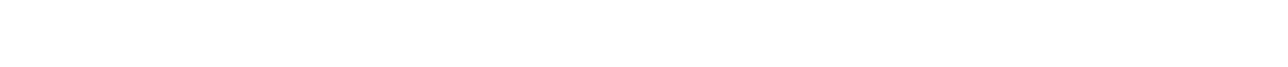

Epoch 32/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


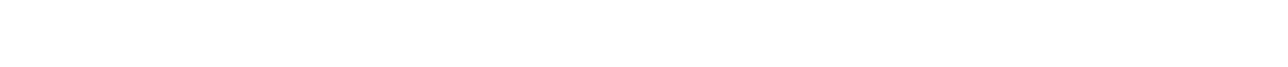

Epoch 33/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


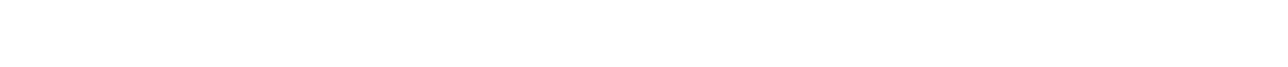

Epoch 34/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


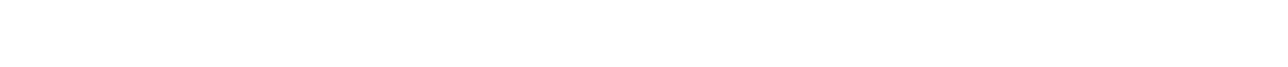

Epoch 35/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


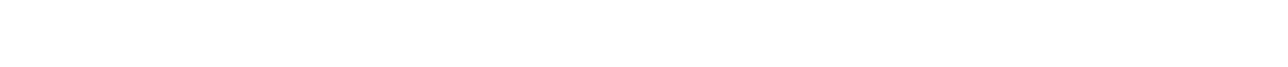

Epoch 36/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


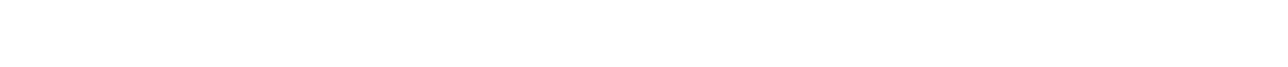

Epoch 37/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


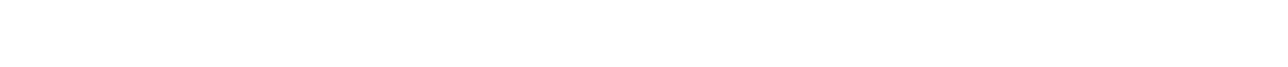

Epoch 38/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


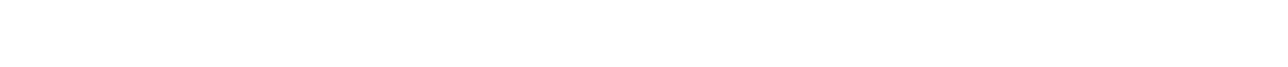

Epoch 39/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


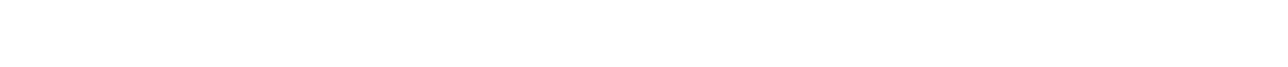

Epoch 40/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


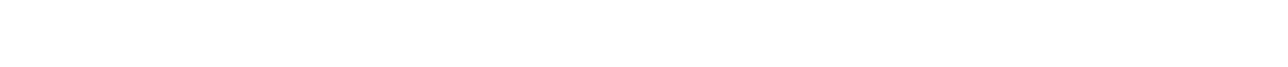

Epoch 41/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


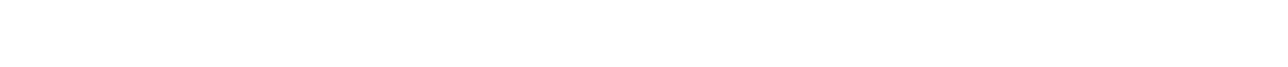

Epoch 42/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


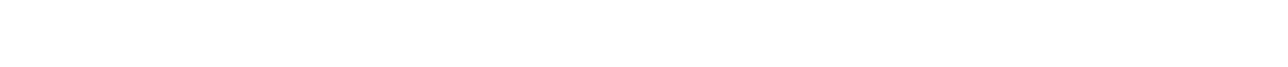

Epoch 43/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


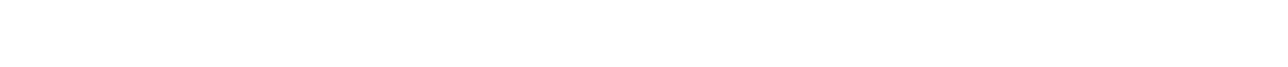

Epoch 44/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


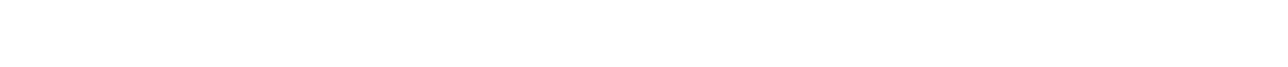

Epoch 45/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


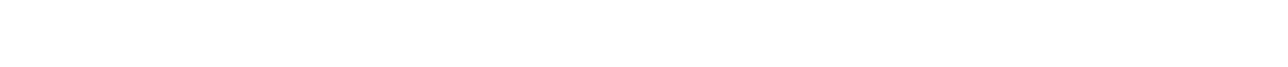

Epoch 46/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


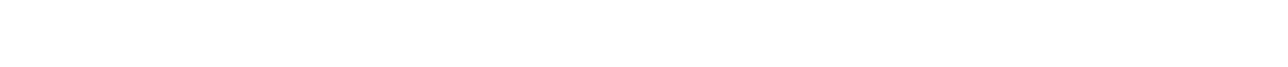

Epoch 47/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


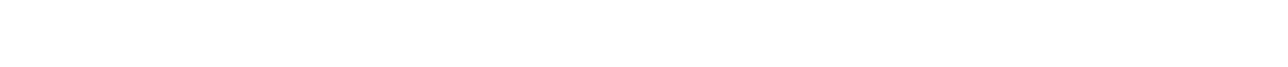

Epoch 48/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


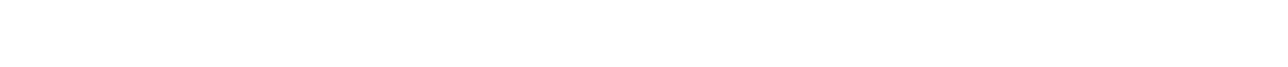

Epoch 49/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


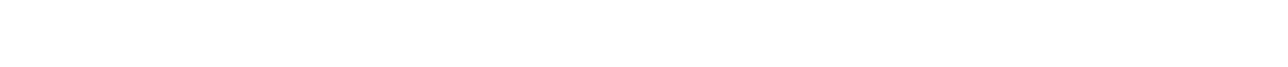

Epoch 50/50 -- ........................................ crit_loss=-1.000, generator_loss=1.000


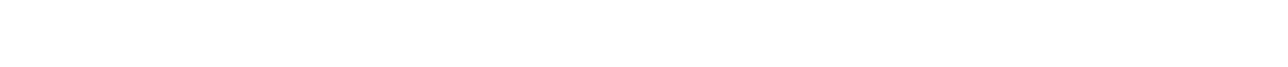

,Epoca,Critic loss,Generator loss
0,0,-1,1
1,1,-1,1
2,2,-1,1
3,3,-1,1
4,4,-1,1
5,5,-1,1
6,6,-1,1
7,7,-1,1
8,8,-1,1
9,9,-1,1


In [ ]:
# Test everything
n_latent_dim = 128

discriminator = define_discriminator_w()
generator = define_generator_w(n_latent_dim)
gan_model = define_gan_w(generator, discriminator)

X = load_dataset()
lista = train3_w(generator, discriminator, gan_model, X, n_latent_dim, n_epochs=50, batch_size=64, visualize=True, n_critic=5)
datafr = pd.DataFrame(lista, columns=["Epoca", "Critic loss", "Generator loss"])
datafr

In [ ]:
#Calculo de datos utilizando dataframes de incisos 1 y 3

print(dataf.mean(axis=0))
print(datafr.mean(axis=0))

Epoca     24.500000
d_real     0.684552
d_fake     0.683956
g          0.764318
dtype: float64
Epoca             24.5
Critic loss       -1.0
Generator loss     1.0
dtype: float64
